# Demand.io Take-Home Assignment - Brief Funnel Analysis


Presented by Jiajun Li.

Last updated on Jan 30th 2024.

This is a brief analysis on each user funnel to answer the following questions:

1. Summarize user activity based on activity count
2. At which stage are we seeing the most drop-off users?
3. Visualize user demographic by device type, geographical loation and traffic sources
4. Apply machine learning models to extract feature importance
6. Possible action to improve user engagement.

I will quickly run through my data preprocessing steps just to make sure everyone is on the same page. Then I'll dive into indepth analysis. Bear with me if the data preprocessing steps sounds boring :)

We will start by exploring the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import geopandas as gpd
import seaborn as sns
plt.style.use('ggplot')

## 1. Data exploration
Here I'll explore the dataset just to have a general idea of what it looks like. I'll continue to see if there's any particular column that needs data cleaning.

In [2]:
df=pd.read_csv('take_home_assignment.csv')
df.head()

,Event Date,Event Timestamp,Event Name,Event Bundle Sequence ID,User Pseudo ID,User First Touch Timestamp,Device,Geo,Traffic Source,Stream ID,Platform,Collected Traffic Source,Is Active User
0,20240107,1.704610e+15,page_view,2010349762,1.116431e+07,1.704340e+15,"[FieldValue{attribute=PRIMITIVE, value=desktop...","[FieldValue{attribute=PRIMITIVE, value=Guanare...","[FieldValue{attribute=PRIMITIVE, value=(organi...",4691994704,WEB,NaN,True
1,20240107,1.704610e+15,page_view,2014156922,1.623039e+09,1.681780e+15,"[FieldValue{attribute=PRIMITIVE, value=desktop...","[FieldValue{attribute=PRIMITIVE, value=Cagayan...","[FieldValue{attribute=PRIMITIVE, value=(direct...",4691994704,WEB,NaN,True
2,20240107,1.704610e+15,promo_button_clicked,2014320234,1.040498e+09,1.704610e+15,"[FieldValue{attribute=PRIMITIVE, value=mobile}...","[FieldValue{attribute=PRIMITIVE, value=Tucson}...","[FieldValue{attribute=PRIMITIVE, value=(organi...",4691994704,WEB,NaN,True
3,20240107,1.704610e+15,promo_button_clicked,2014323496,1.040498e+09,1.704610e+15,"[FieldValue{attribute=PRIMITIVE, value=mobile}...","[FieldValue{attribute=PRIMITIVE, value=Tucson}...","[FieldValue{attribute=PRIMITIVE, value=(organi...",4691994704,WEB,NaN,True
4,20240107,1.704610e+15,promo_button_clicked,2016981860,2.292186e+08,1.704610e+15,"[FieldValue{attribute=PRIMITIVE, value=mobile}...","[FieldValue{attribute=PRIMITIVE, value=Dubai},...","[FieldValue{attribute=PRIMITIVE, value=(organi...",4691994704,WEB,NaN,True


Some columns contains either irrelavant or duplicate data for analysis or identical elements throughout the entire column, assuming we are not doing a time series analysis here, so I'll drop these columns for now.

In [3]:
df.drop(columns=['Event Date','Event Timestamp','Event Bundle Sequence ID', 'User First Touch Timestamp','Stream ID','Platform','Collected Traffic Source'],inplace=True)
df.head()

,Event Name,User Pseudo ID,Device,Geo,Traffic Source,Is Active User
0,page_view,1.116431e+07,"[FieldValue{attribute=PRIMITIVE, value=desktop...","[FieldValue{attribute=PRIMITIVE, value=Guanare...","[FieldValue{attribute=PRIMITIVE, value=(organi...",True
1,page_view,1.623039e+09,"[FieldValue{attribute=PRIMITIVE, value=desktop...","[FieldValue{attribute=PRIMITIVE, value=Cagayan...","[FieldValue{attribute=PRIMITIVE, value=(direct...",True
2,promo_button_clicked,1.040498e+09,"[FieldValue{attribute=PRIMITIVE, value=mobile}...","[FieldValue{attribute=PRIMITIVE, value=Tucson}...","[FieldValue{attribute=PRIMITIVE, value=(organi...",True
3,promo_button_clicked,1.040498e+09,"[FieldValue{attribute=PRIMITIVE, value=mobile}...","[FieldValue{attribute=PRIMITIVE, value=Tucson}...","[FieldValue{attribute=PRIMITIVE, value=(organi...",True
4,promo_button_clicked,2.292186e+08,"[FieldValue{attribute=PRIMITIVE, value=mobile}...","[FieldValue{attribute=PRIMITIVE, value=Dubai},...","[FieldValue{attribute=PRIMITIVE, value=(organi...",True


Here's the summary of user activities:

In [4]:
# Count of each event type
event_type_counts = df['Event Name'].value_counts().rename('Event Count')
unique_users_per_event = df.groupby('Event Name')['User Pseudo ID'].nunique().rename('Unique Users')
summary_df = pd.concat([event_type_counts, unique_users_per_event], axis=1)
summary_df=summary_df.sort_values('Unique Users',ascending=False)
summary_df

,Event Count,Unique Users
Event Name,,
page_view,836,421
session_start,398,398
first_visit,330,330
promo_button_clicked,437,175


Wiith only 175 out of 421 users who visited the page clicking on the promo button, there is a significant drop-off.

To dive into details, I'll go ahead and clean out the data in Device, Geo and Traffic Source columns to see if we can get some insights from there.

## 2. Data cleaning
There are some data columns that required to be cleaned, namely Device column, Geo column and Traffic Source column. They look like JAVA object strings. I'll try to extract the corresponding information from each of these columns.

### a) Parse values function
A function will take java object string and return all necessary values:

In [5]:
def parse_values(str):
    """
    Parses the java object string to extract information.

    Returns:
    list: A list of extracted values.
    """
    # Regular expression pattern to match the values after "value="
    pattern = r'value=([^\},]+)'

    # Extracting all matches
    values = re.findall(pattern, str)
    return values

### b) Parse values from Device, Geo and Traffic Source columns
Using the function above, I'll translate the JAVA object strings into readable tables for device types, geo-location and traffic source.

#### 1) Device Column

In [6]:
# Apply the function to the 'Device' column and create new columns for each extracted value
parsed_device_data = df['Device'].apply(parse_values)
device_columns_df = pd.DataFrame(parsed_device_data.tolist())
device_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,desktop,Microsoft,Edge,null,null,Windows,Windows 10,null,null,es-419,No,null,null,null,[FieldValue{attribute=PRIMITIVE,Edge,120.0.2210.91,knoji.com
1,desktop,Google,Chrome,null,null,Windows,Windows 11,null,null,en-us,No,null,null,null,[FieldValue{attribute=PRIMITIVE,Chrome,120.0.6099.131,knoji.com
2,mobile,Apple,iPhone,null,null,iOS,iOS 17.2.1,null,null,en-us,No,null,null,null,[FieldValue{attribute=PRIMITIVE,Safari,605.1.15,jackpocket.knoji.com
3,mobile,Apple,iPhone,null,null,iOS,iOS 17.2.1,null,null,en-us,No,null,null,null,[FieldValue{attribute=PRIMITIVE,Safari,605.1.15,jackpocket.knoji.com
4,mobile,Apple,iPhone,null,null,iOS,iOS 17.0.2,null,null,en-us,No,null,null,null,[FieldValue{attribute=PRIMITIVE,Safari,17.0,fruugo.knoji.com


After reading out unique values and duplicate information in all these columns, I feel like some columns are safe to be dropped.

In [7]:
device_columns_df.drop(columns=[2,3,4,6,7,8,10,11,12,13,14,16,17],inplace=True)

And here's the cleaned device data:

In [8]:
device_column_names = ['Device Type', 'Manufacturer',  'System', 'Language', 'Browser']
device_columns_df.columns=device_column_names
device_columns_df.head()

,Device Type,Manufacturer,System,Language,Browser
0,desktop,Microsoft,Windows,es-419,Edge
1,desktop,Google,Windows,en-us,Chrome
2,mobile,Apple,iOS,en-us,Safari
3,mobile,Apple,iOS,en-us,Safari
4,mobile,Apple,iOS,en-us,Safari


In [9]:
device_columns_df.describe()

,Device Type,Manufacturer,System,Language,Browser
count,2001,2001,2001,2001,2001
unique,3,17,6,33,9
top,mobile,Apple,iOS,en-us,Chrome
freq,1224,1119,837,1293,889


#### 2) Geo column

In [10]:
# Apply the function to the 'Geo' column and create new columns for each extracted value
parsed_geo_data = df['Geo'].apply(parse_values)
geo_columns_df = pd.DataFrame(parsed_geo_data.tolist())
geo_columns_df.head()

,0,1,2,3,4,5
0,Guanare,Venezuela,Americas,Portuguesa,South America,(not set)
1,Cagayan de Oro,Philippines,Asia,Northern Mindanao,Southeast Asia,(not set)
2,Tucson,United States,Americas,Arizona,Northern America,Tucson (Sierra Vista) AZ
3,Tucson,United States,Americas,Arizona,Northern America,Tucson (Sierra Vista) AZ
4,Dubai,United Arab Emirates,Asia,Dubai,Western Asia,(not set)


Since all the columns are necessary for analysis, I'll keep all these columns.

Here's a cleaner geo-location dataset.

In [11]:
geo_column_names = ['City', 'Country', 'Continent', 'State', 'Sub-Continent', 'City-State']
geo_columns_df.columns = geo_column_names
geo_columns_df.head()

,City,Country,Continent,State,Sub-Continent,City-State
0,Guanare,Venezuela,Americas,Portuguesa,South America,(not set)
1,Cagayan de Oro,Philippines,Asia,Northern Mindanao,Southeast Asia,(not set)
2,Tucson,United States,Americas,Arizona,Northern America,Tucson (Sierra Vista) AZ
3,Tucson,United States,Americas,Arizona,Northern America,Tucson (Sierra Vista) AZ
4,Dubai,United Arab Emirates,Asia,Dubai,Western Asia,(not set)


In [12]:
geo_columns_df.describe()

,City,Country,Continent,State,Sub-Continent,City-State
count,2001,2001,2001,2001,1920,1766
unique,294,47,32,131,28,84
top,United States,United States,Americas,California,Northern America,(not set)
freq,107,1015,1132,228,1077,632


#### 3) Traffic Source column

In [13]:
# Apply the function to the 'Traffic Source' column and create new columns for each extracted value
parsed_traffic_source_data = df['Traffic Source'].apply(parse_values)
traffic_source_columns_df = pd.DataFrame(parsed_traffic_source_data.tolist())
traffic_source_columns_df.head()

,0,1,2
0,(organic),organic,google
1,(direct),(none),(direct)
2,(organic),organic,google
3,(organic),organic,google
4,(organic),organic,google


After reading out unique values for each column, I feel like column 0 and 1 contains duplicate information so I'll drop column 0 here.

In [14]:
traffic_source_columns_df.drop(columns=[0],inplace=True)

And the readable table for traffic source is below:

In [15]:
traffic_source_column_names = ['Source','External Site']
traffic_source_columns_df.columns=traffic_source_column_names
traffic_source_columns_df.head()

,Source,External Site
0,organic,google
1,(none),(direct)
2,organic,google
3,organic,google
4,organic,google


In [16]:
traffic_source_columns_df.describe()

,Source,External Site
count,2001,2001
unique,4,15
top,organic,google
freq,1731,1583


### c) Refine main dataframe
Here is a more refined dataframe to read.

In [17]:
df_refined=pd.concat((df,device_columns_df,geo_columns_df,traffic_source_columns_df),axis=1)
df_refined.drop(columns=['Device','Geo','Traffic Source'],inplace=True)
df_refined.to_csv('refined data.csv',index=False)
df_refined.head()

,Event Name,User Pseudo ID,Is Active User,Device Type,Manufacturer,System,Language,Browser,City,Country,Continent,State,Sub-Continent,City-State,Source,External Site
0,page_view,1.116431e+07,True,desktop,Microsoft,Windows,es-419,Edge,Guanare,Venezuela,Americas,Portuguesa,South America,(not set),organic,google
1,page_view,1.623039e+09,True,desktop,Google,Windows,en-us,Chrome,Cagayan de Oro,Philippines,Asia,Northern Mindanao,Southeast Asia,(not set),(none),(direct)
2,promo_button_clicked,1.040498e+09,True,mobile,Apple,iOS,en-us,Safari,Tucson,United States,Americas,Arizona,Northern America,Tucson (Sierra Vista) AZ,organic,google
3,promo_button_clicked,1.040498e+09,True,mobile,Apple,iOS,en-us,Safari,Tucson,United States,Americas,Arizona,Northern America,Tucson (Sierra Vista) AZ,organic,google
4,promo_button_clicked,2.292186e+08,True,mobile,Apple,iOS,en-us,Safari,Dubai,United Arab Emirates,Asia,Dubai,Western Asia,(not set),organic,google


With data cleaned up, I'll go ahead to do some analytics here.

All the analysis conducted below are subjective to my personal favor, meaning there could be better solutions if given more instructions.

## 3. User analytics
To further explore user device types, demographics and traffic source, I'll start by visualizing these dataset.

### a) User geographics

In [18]:
# countries we have covered
geo_columns_df['Country'].unique()

array(['Venezuela', 'Philippines', 'United States',
       'United Arab Emirates', 'Asia', 'Canada', 'Germany', 'Australia',
       'Japan', 'Americas', 'Pakistan', 'India', 'United Kingdom',
       'Poland', 'Botswana', 'Finland', 'New Zealand', 'Israel',
       'Malaysia', 'Europe', 'Oceania', 'South Korea', 'Saudi Arabia',
       'Belarus', 'France', 'Bangladesh', 'Singapore', 'Vietnam',
       'Austria', 'Mexico', 'Greece', 'Indonesia', 'Sri Lanka', 'Chile',
       'Switzerland', 'Russia', 'Italy', 'Portugal', 'Egypt',
       'Netherlands', 'Spain', 'Taiwan', 'Türkiye', 'Belgium', 'Sweden',
       'Nigeria', 'Ukraine'], dtype=object)

#### 1) World-wide geographic

In [19]:
# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Creating a mapping of country names from the dataset to the world map data
country_name_mapping = {
    'United States': 'United States of America',
    'Russia': 'Russia',  # Assuming Russia refers to the Russian Federation
    'South Korea': 'South Korea',  # South Korea is officially the Republic of Korea
    'Türkiye': 'Turkey',  # Türkiye is the local name for Turkey
    # Additional mappings can be added here as needed
}

# Applying the mapping to the dataset
geo_columns_df['Mapped Country'] = geo_columns_df['Country'].replace(country_name_mapping)

# Re-aggregate the data by the updated country names
country_counts_updated = geo_columns_df['Mapped Country'].value_counts().reset_index()
country_counts_updated.columns = ['country', 'count']

# Merge the updated data with the world map data
world_map_updated = world.merge(country_counts_updated, how='left', left_on='name', right_on='country')

C:\Users\37597\AppData\Local\Temp\ipykernel_9756\2179583329.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


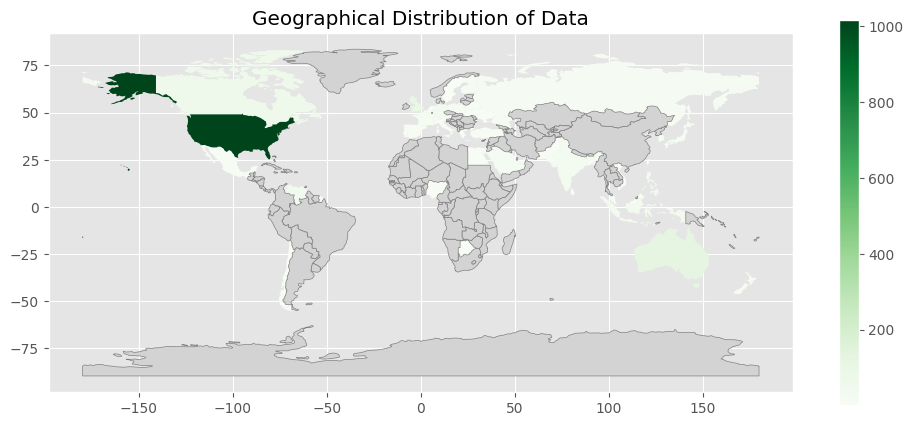

In [20]:
# Plotting the updated map
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
world_map_updated.plot(column='count', ax=ax, legend=True, cmap='Greens', missing_kwds={
    "color": "lightgrey",
    "edgecolor": "grey",
    "label": "Missing data",
})
plt.title('Geographical Distribution of Data')
plt.show()

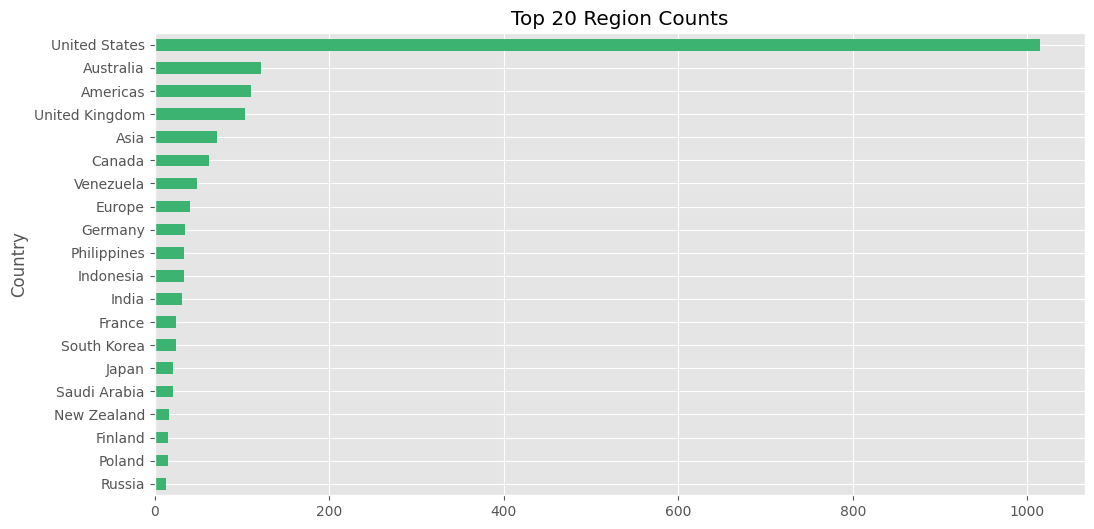

In [21]:
country_counts = geo_columns_df['Country'].value_counts().head(20)

# Plotting a horizontal bar chart for country counts
plt.figure(figsize=(12, 6))
country_counts.plot(kind='barh',color='mediumseagreen')
plt.title('Top 20 Region Counts')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

#### 2) United States Geographic
I'll plot the user activity on map based on states and list acitivity ranks based on cities.

In [22]:
# load the states data
usa_columns_df=geo_columns_df[geo_columns_df['Country']=='United States']
usa_columns_df=usa_columns_df.drop(columns=['Country','Continent','Sub-Continent','City-State'],axis=1)

# Load the map of the United States
us_states_url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
us_map = gpd.read_file(us_states_url)

# Aggregate the data by State_Region to get counts for each state
state_counts = usa_columns_df['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

# Merging the counts with the US map
merged_map = us_map.set_index('name').join(state_counts.set_index('State'))


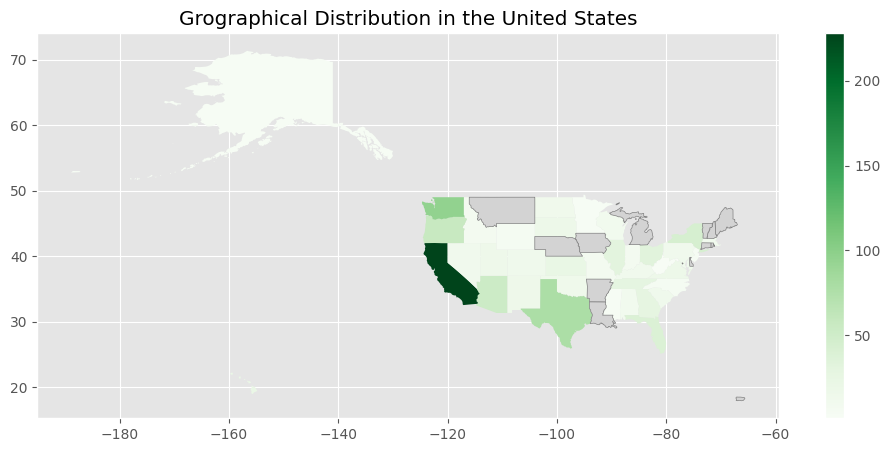

In [23]:
# Plotting the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
merged_map.plot(column='Count', ax=ax, legend=True, cmap='Greens', missing_kwds={
    "color": "lightgrey",
    "edgecolor": "grey",
    "label": "Missing data",
})
plt.title('Grographical Distribution in the United States')
plt.show()

And here is the ranking of cities.

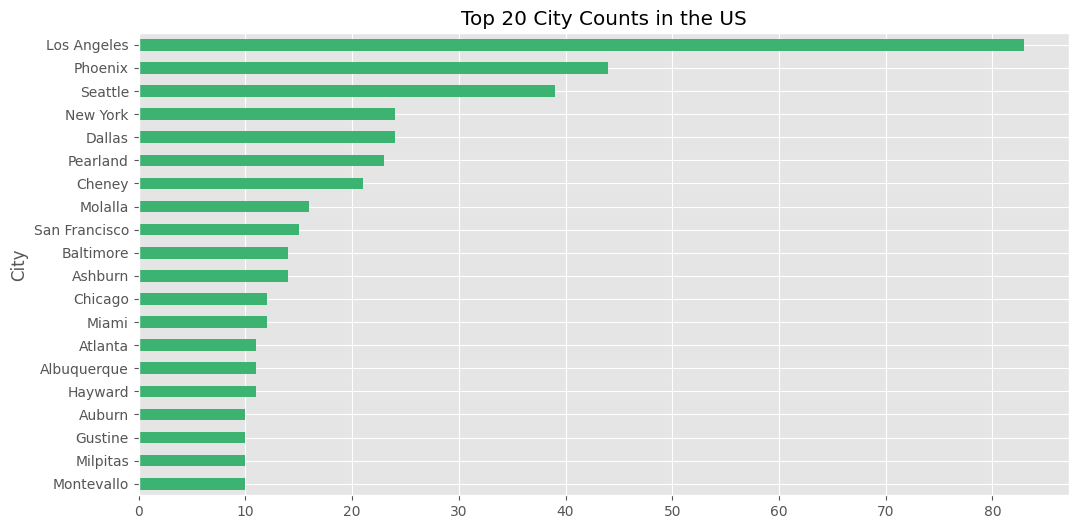

In [24]:
city_counts = usa_columns_df['City'].value_counts().head(20)

# Plotting a horizontal bar chart for country counts
plt.figure(figsize=(12, 6))
city_counts.plot(kind='barh',color='mediumseagreen')
plt.title('Top 20 City Counts in the US')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Here are the states with zero user activities:

In [25]:
us_states_list = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
    'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
    'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
    'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
    'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

states_in_dataset = set(usa_columns_df['State'].dropna().unique())

In [26]:
# Missing states in the dataset
missing_states = [state for state in us_states_list if state not in states_in_dataset]
missing_states

['Arkansas',
 'Connecticut',
 'Delaware',
 'Iowa',
 'Louisiana',
 'Maine',
 'Michigan',
 'Montana',
 'Nebraska',
 'New Hampshire',
 'Rhode Island',
 'Vermont']

### b) User device destribution

In [27]:
# Function to create a bar chart for each column
def plot_percentage_bar_chart(dataframe, column):
    # Calculate the percentage of each category in the column
    percentage = dataframe[column].value_counts(normalize=True) * 100

    # Plotting
    plt.figure(figsize=(12, 5))
    percentage.plot(kind='bar',color='mediumseagreen')
    plt.title(f'Percentage Distribution of {column}')
    plt.ylabel('Percentage (%)')
    plt.xlabel(column)
    plt.xticks(rotation=45, ha='right')

In [28]:
device_columns_df

,Device Type,Manufacturer,System,Language,Browser
0,desktop,Microsoft,Windows,es-419,Edge
1,desktop,Google,Windows,en-us,Chrome
2,mobile,Apple,iOS,en-us,Safari
3,mobile,Apple,iOS,en-us,Safari
4,mobile,Apple,iOS,en-us,Safari
...,...,...,...,...,...
1996,desktop,Google,Windows,en-us,Chrome
1997,desktop,Google,Windows,en-us,Chrome
1998,mobile,Apple,iOS,en-us,Safari
1999,mobile,Apple,iOS,en-us,Safari


Here are user distribution by device types, manufacturers, operating systems, languages and browsers.

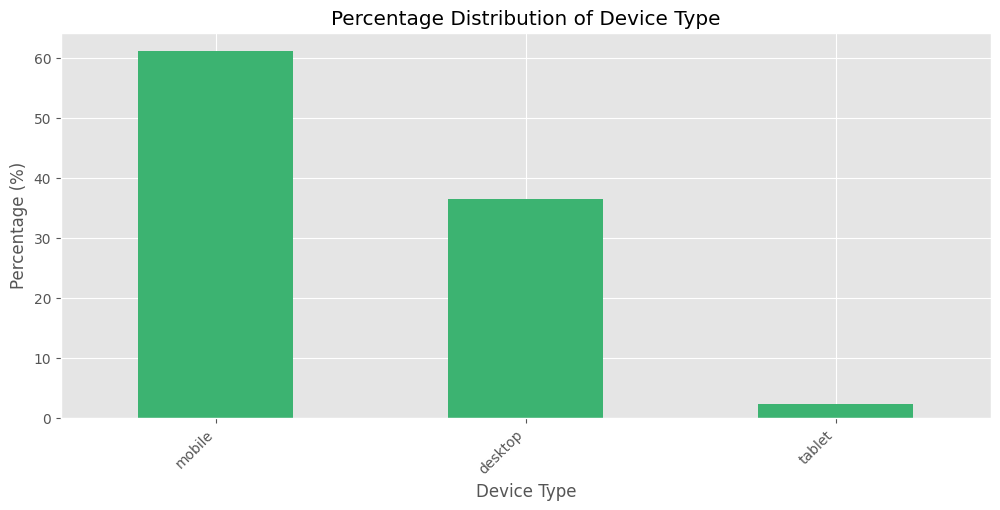

In [29]:
plot_percentage_bar_chart(device_columns_df,'Device Type')

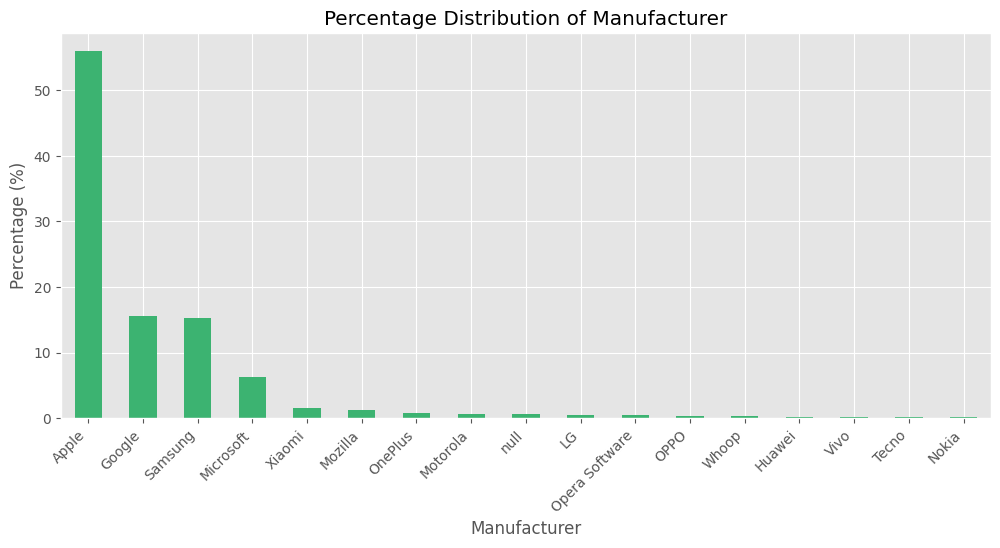

In [30]:
plot_percentage_bar_chart(device_columns_df,'Manufacturer')

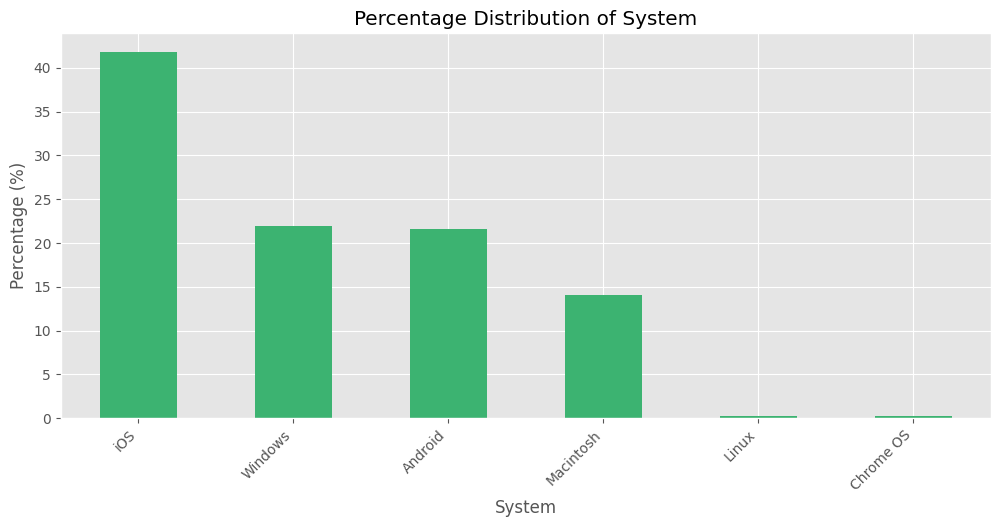

In [31]:
plot_percentage_bar_chart(device_columns_df,'System')

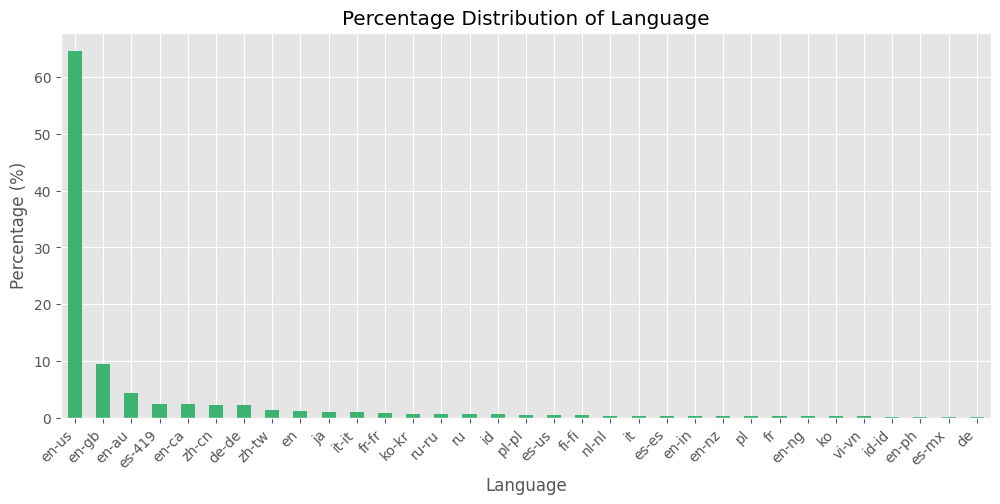

In [32]:
plot_percentage_bar_chart(device_columns_df,'Language')

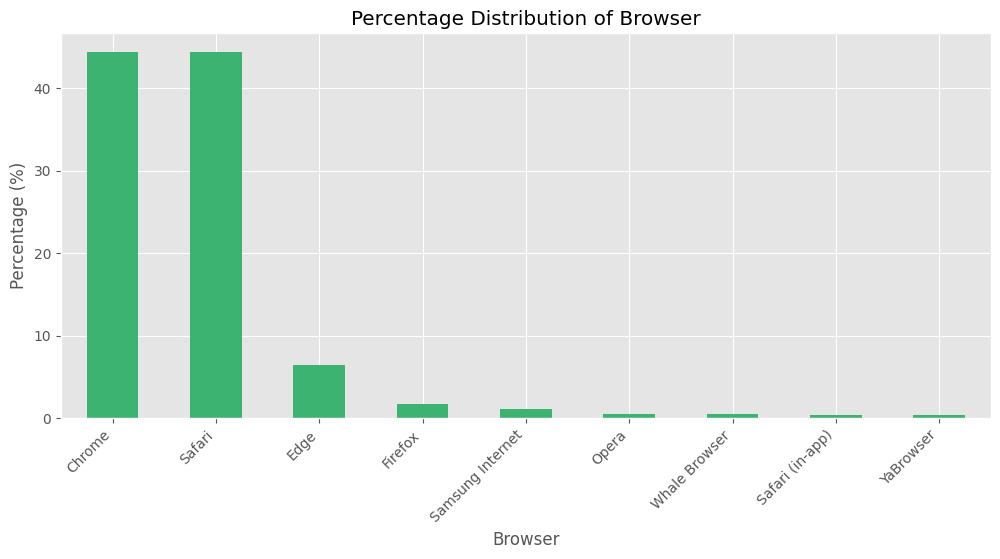

In [33]:
plot_percentage_bar_chart(device_columns_df,'Browser')

English-speaking mobile users on Apple devices are the major user base.

Chrome and Safari are the two major browsers for the platform. 

We are also seeing potential opportunities in non-English communities as Spanish, German and Chinese are among top 10 in terms of user language.

### c) User traffic source

In [34]:
traffic_source_count = traffic_source_columns_df.value_counts()
traffic_source_count

Source    External Site      
organic   google                 1583
(none)    (direct)                236
organic   bing                     84
          yahoo                    34
          duckduckgo               17
          ecosia.org               10
referral  m.facebook.com            9
          uk.search.yahoo.com       6
          yandex.ru                 6
          m.ok.ru                   4
rtb-cpm   yandex                    4
organic   baidu                     3
referral  yandex.by                 3
          ph.search.yahoo.com       1
          tw.search.yahoo.com       1
Name: count, dtype: int64

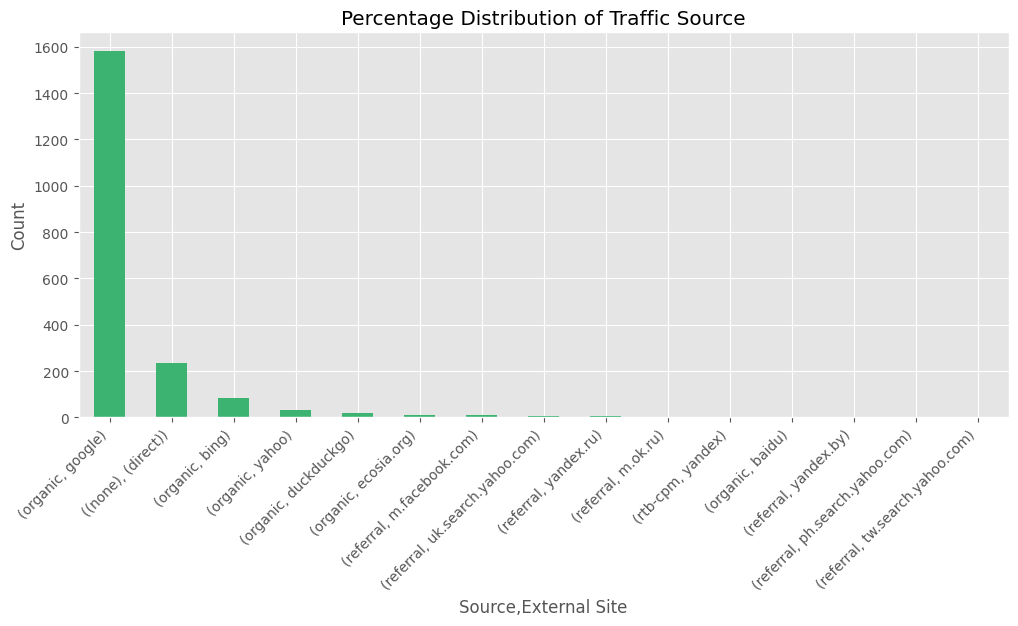

In [35]:
plt.figure(figsize=(12, 5))
traffic_source_count.plot(kind='bar',color='mediumseagreen')
plt.title('Percentage Distribution of Traffic Source')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

Google Ads still plays a significant role driving external traffic onto the platform.

## 4. Analysis on drop-off users
To further identify the characteristics of drop-off users, I have identified drop-off points by comparing the number of users between stages (from page view to promo button clicked).

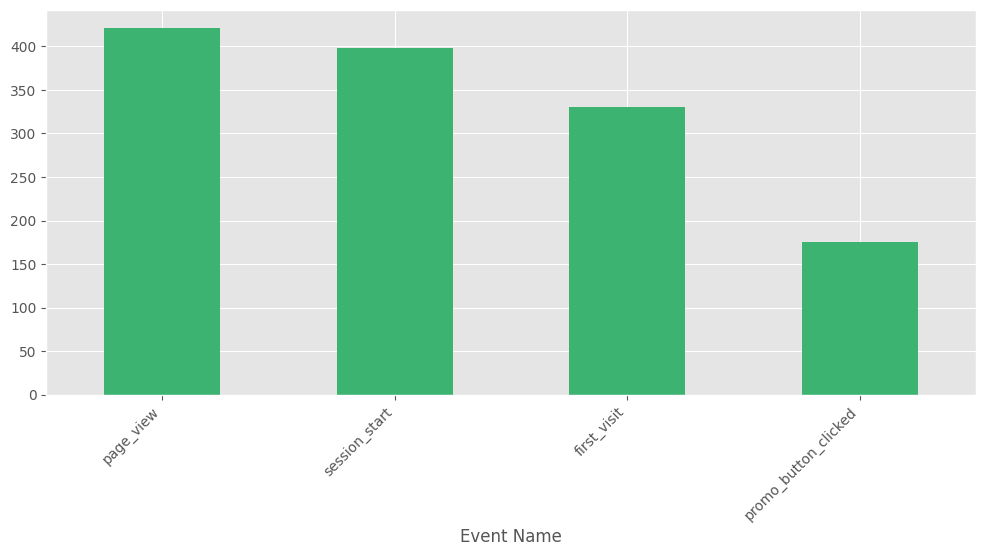

In [36]:
plt.figure(figsize=(12, 5))
summary_df['Unique Users'].plot.bar(color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.show()

There are less than 50% unique users who viewed our page but did not click promo button.

Now I will break down the analysis by geo-location, device type and traffic source.

### a) Identify drop-off users
I will filter the dataset for relevant events: 'first_visit' and 'promo_button_clicked', assuming 'first_visit' can be represented by 'page_view' as the first interaction.

In [37]:
# Filter for 'page_view' and 'promo_button_clicked' events
relevant_events = ['page_view', 'promo_button_clicked']
filtered_data = df_refined[df_refined['Event Name'].isin(relevant_events)]
filtered_data.to_csv('filtered_data.csv',index=False)
filtered_data.head()

,Event Name,User Pseudo ID,Is Active User,Device Type,Manufacturer,System,Language,Browser,City,Country,Continent,State,Sub-Continent,City-State,Source,External Site
0,page_view,1.116431e+07,True,desktop,Microsoft,Windows,es-419,Edge,Guanare,Venezuela,Americas,Portuguesa,South America,(not set),organic,google
1,page_view,1.623039e+09,True,desktop,Google,Windows,en-us,Chrome,Cagayan de Oro,Philippines,Asia,Northern Mindanao,Southeast Asia,(not set),(none),(direct)
2,promo_button_clicked,1.040498e+09,True,mobile,Apple,iOS,en-us,Safari,Tucson,United States,Americas,Arizona,Northern America,Tucson (Sierra Vista) AZ,organic,google
3,promo_button_clicked,1.040498e+09,True,mobile,Apple,iOS,en-us,Safari,Tucson,United States,Americas,Arizona,Northern America,Tucson (Sierra Vista) AZ,organic,google
4,promo_button_clicked,2.292186e+08,True,mobile,Apple,iOS,en-us,Safari,Dubai,United Arab Emirates,Asia,Dubai,Western Asia,(not set),organic,google


Here I'll group by these categories and count unique users at the two different stages.

In [38]:
geo_location_dropoff = filtered_data.groupby(['Event Name', 'Country', 'City', 'State']).agg({'User Pseudo ID': 'nunique'})
device_type_dropoff = filtered_data.groupby(['Event Name', 'Device Type','System','Browser']).agg({'User Pseudo ID': 'nunique'})
traffic_source_dropoff = filtered_data.groupby(['Event Name', 'Source','External Site']).agg({'User Pseudo ID': 'nunique'})

### b) Drop-off points by geo location
The data shows drop-off user demographics broken down by country, city, and state.

In [39]:
# Preparing the data for visualization
geo_location_dropoff_reset = geo_location_dropoff.reset_index()
geo_location_dropoff_pivot = geo_location_dropoff_reset.pivot_table(
    index=['Country', 'City', 'State'], 
    columns='Event Name', 
    values='User Pseudo ID'
).reset_index()

# filling na with zeros
geo_location_dropoff_pivot.fillna(0, inplace=True)

In [40]:
# adding drop-off count and rate
geo_location_dropoff_pivot['Drop-off Count'] = geo_location_dropoff_pivot['page_view'] - geo_location_dropoff_pivot['promo_button_clicked']
geo_location_dropoff_pivot['Drop-off Rate'] = 1 - (geo_location_dropoff_pivot['promo_button_clicked'] / geo_location_dropoff_pivot['page_view'])

In [41]:
# Sorting by drop-off count for visualization
geo_location_dropoff_sorted = geo_location_dropoff_pivot.sort_values('Drop-off Count', ascending=False).head(100)

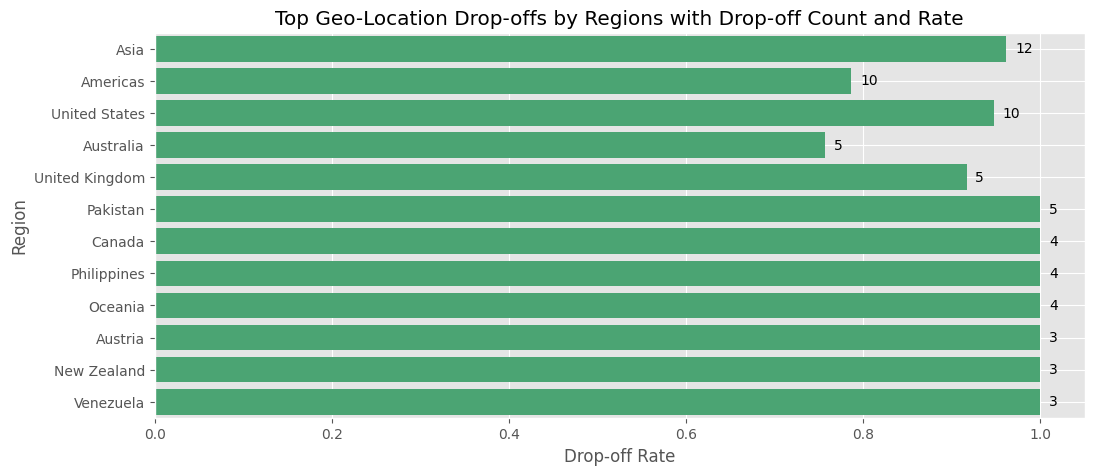

In [42]:
fig1, ax1 = plt.subplots(figsize=(12, 5))
sns.barplot(x='Drop-off Rate', y='Country', data=geo_location_dropoff_sorted, ax=ax1, color='mediumseagreen', errorbar=None)
ax1.set_title('Top Geo-Location Drop-offs by Regions with Drop-off Count and Rate')
ax1.set_xlabel('Drop-off Rate')
ax1.set_ylabel('Region')
for i, p in enumerate(ax1.patches):
    rate = geo_location_dropoff_sorted['Drop-off Count'].iloc[i]
    ax1.text(p.get_width() + 0.01,  p.get_y() + p.get_height() / 2, f'{rate:.0f}', ha='left', va='center')
ax1.grid(True)
plt.show()

This graph displays the top geo-location drop-offs based on the country. Each bar represents a region (country or continent) and the length of the bar indicates the count of users who viewed the page but did not click on the promo button.

Asia and Americas (including United States) are among the top 2 drop-off regions. Since United States are the largest user base, we should emphasize the localization for non-US regions. Users over there either don't necessarily read English quite well, or they can't get a good deal or effective code through our platform.

### c) Drop-off points by device type
I'll apply similar method to demonstrate drop-off points here.

In [43]:
# Visualizing the drop-off based on device type

# Preparing the data for visualization by Device Type
device_type_dropoff_reset = device_type_dropoff.reset_index()
device_type_dropoff_pivot = device_type_dropoff_reset.pivot_table(
    index=['Device Type','System','Browser'],
    columns='Event Name', 
    values='User Pseudo ID'
).reset_index()

device_type_dropoff_pivot.fillna(0, inplace=True)
device_type_dropoff_pivot.head()

# Filling NaN values with 0 and calculating drop-off count
device_type_dropoff_pivot.fillna(0, inplace=True)
device_type_dropoff_pivot['Drop-off Count'] = device_type_dropoff_pivot['page_view'] - device_type_dropoff_pivot['promo_button_clicked']
device_type_dropoff_pivot['Drop-off Rate'] = 1 - (device_type_dropoff_pivot['promo_button_clicked'] / device_type_dropoff_pivot['page_view'])

# Sorting by drop-off count for visualization
device_type_dropoff_sorted = device_type_dropoff_pivot.sort_values('Drop-off Count', ascending=False)

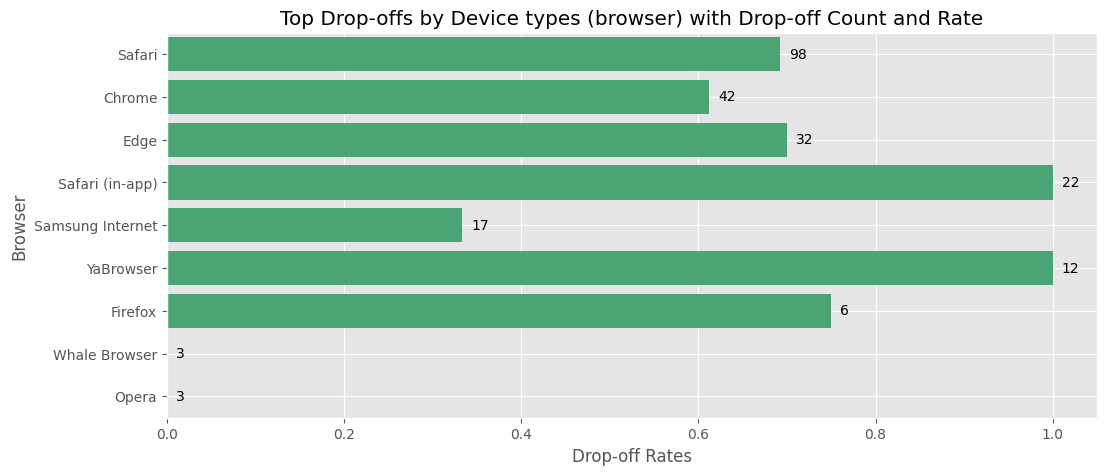

In [44]:
fig2, ax2 = plt.subplots(figsize=(12, 5))
sns.barplot(x='Drop-off Rate', y='Browser', data=device_type_dropoff_sorted, ax=ax2, color='mediumseagreen', errorbar=None)
ax2.set_title('Top Drop-offs by Device types (browser) with Drop-off Count and Rate')
ax2.set_xlabel('Drop-off Rates')
ax2.set_ylabel('Browser')
for i, p in enumerate(ax2.patches):
    rate = device_type_dropoff_sorted['Drop-off Count'].iloc[i]
    ax2.text(p.get_width() + 0.01, p.get_y() + p.get_height() / 2, f'{rate:.0f}', ha='left', va='center')
ax2.grid(True)
plt.show()

Safari (in-app) is both high in drop-off count and rate (22 drop-offs with a 100% rate), meaning Safari (in-app) users don't particularly like to use our platform so much. Further investigation is needed here.

### d) Drop-off points by traffic source


In [45]:
# Visualizing the drop-off based on traffic source

# Preparing the data for visualization by traffic source
traffic_source_dropoff_reset = traffic_source_dropoff.reset_index()
traffic_source_dropoff_pivot = traffic_source_dropoff_reset.pivot_table(
    index=['Source','External Site'],
    columns='Event Name', 
    values='User Pseudo ID'
).reset_index()

# filling na with zeros
traffic_source_dropoff_pivot.fillna(0, inplace=True)
traffic_source_dropoff_pivot.head()

# Filling NaN values with 0 and calculating drop-off count
traffic_source_dropoff_pivot.fillna(0, inplace=True)
traffic_source_dropoff_pivot['Drop-off Count'] = traffic_source_dropoff_pivot['page_view'] - traffic_source_dropoff_pivot['promo_button_clicked']
traffic_source_dropoff_pivot['Drop-off Rate'] = 1 - (traffic_source_dropoff_pivot['promo_button_clicked'] / traffic_source_dropoff_pivot['page_view'])

# Sorting by drop-off count for visualization
traffic_source_dropoff_sorted = traffic_source_dropoff_pivot.sort_values('Drop-off Count', ascending=False)

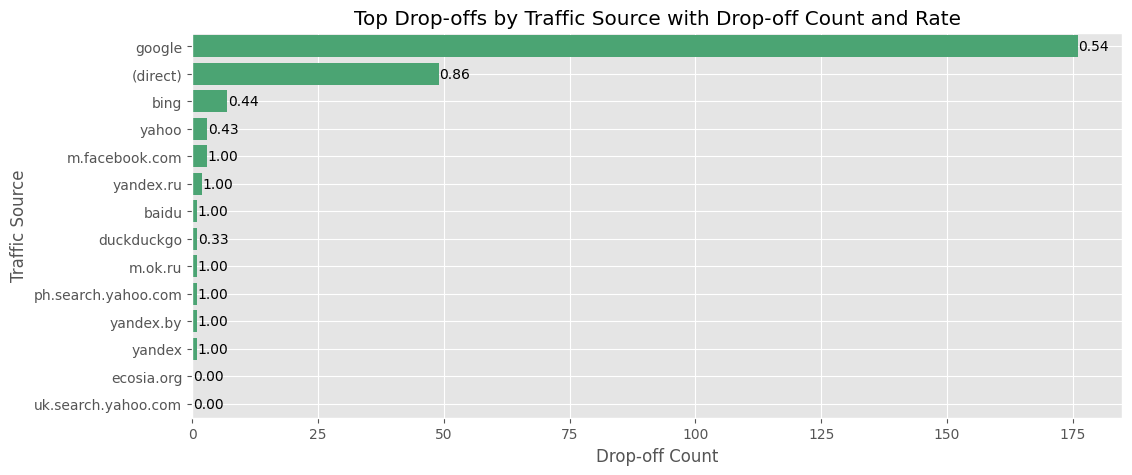

In [46]:
fig3, ax3 = plt.subplots(figsize=(12, 5))
sns.barplot(x='Drop-off Count', y='External Site', data=traffic_source_dropoff_sorted, ax=ax3, color='mediumseagreen', errorbar=None)
ax3.set_title('Top Drop-offs by Traffic Source with Drop-off Count and Rate')
ax3.set_xlabel('Drop-off Count')
ax3.set_ylabel('Traffic Source')
for i, p in enumerate(ax3.patches):
    rate = traffic_source_dropoff_sorted['Drop-off Rate'].iloc[i]
    ax3.text(p.get_width() + 0.1, p.get_y() + p.get_height() / 2, f'{rate:.2f}', ha='left', va='center')
ax3.grid(True)
plt.show()

Even Google has the highest drop-off count, given Google is also the biggest traffic source, and the drop-off rate is somewhat not so high, I think we should focus on the direct source, especially because it has 86% drop-off rate.

Also notice that duckgogo has a very low drop-off rate at 33%, meaning its users knows what they are searching for.

## 5. Machine learning models
To see the importance of each feature and predict the likelihood of conversion, I built out two machine learning models (logistic regression and random forest) to see if these models could be applied to the product to further improve conversion rates.

In [47]:
import sklearn

### a) data preprocessing
I'll use the previously refined dataframe to build out the models. Please be noted that it does not come with timestamps. 

In [48]:
filtered_data.head()

,Event Name,User Pseudo ID,Is Active User,Device Type,Manufacturer,System,Language,Browser,City,Country,Continent,State,Sub-Continent,City-State,Source,External Site
0,page_view,1.116431e+07,True,desktop,Microsoft,Windows,es-419,Edge,Guanare,Venezuela,Americas,Portuguesa,South America,(not set),organic,google
1,page_view,1.623039e+09,True,desktop,Google,Windows,en-us,Chrome,Cagayan de Oro,Philippines,Asia,Northern Mindanao,Southeast Asia,(not set),(none),(direct)
2,promo_button_clicked,1.040498e+09,True,mobile,Apple,iOS,en-us,Safari,Tucson,United States,Americas,Arizona,Northern America,Tucson (Sierra Vista) AZ,organic,google
3,promo_button_clicked,1.040498e+09,True,mobile,Apple,iOS,en-us,Safari,Tucson,United States,Americas,Arizona,Northern America,Tucson (Sierra Vista) AZ,organic,google
4,promo_button_clicked,2.292186e+08,True,mobile,Apple,iOS,en-us,Safari,Dubai,United Arab Emirates,Asia,Dubai,Western Asia,(not set),organic,google


Get dummy variables by one-hot encoding, generate synthetic samples to handle imbalanced data (SMOTE) and split train and test data:

In [49]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = filtered_data.select_dtypes(include=['object']).columns
encoded_features = encoder.fit_transform(filtered_data[categorical_features])
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
encoded_features_df.head()

,Event Name_page_view,Event Name_promo_button_clicked,Device Type_desktop,Device Type_mobile,Device Type_tablet,Manufacturer_Apple,Manufacturer_Google,Manufacturer_Huawei,Manufacturer_LG,Manufacturer_Microsoft,...,External Site_ecosia.org,External Site_google,External Site_m.facebook.com,External Site_m.ok.ru,External Site_ph.search.yahoo.com,External Site_uk.search.yahoo.com,External Site_yahoo,External Site_yandex,External Site_yandex.by,External Site_yandex.ru
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
X=encoded_features_df.drop(columns=['Event Name_page_view','Event Name_promo_button_clicked'])
y=encoded_features_df['Event Name_promo_button_clicked']
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,y,train_size=0.8)

In [51]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(k_neighbors=100) 
X_SMOTE,y_smote=smote.fit_resample(X,y)
X_train_smote,X_test_smote,Y_train_smote,Y_test_smote=train_test_split(X_SMOTE,y_smote,stratify=y_smote)

### b) Machine learning models
I'll use logistic regression and random forest models to compare the accuracy and try to extract feature importance.

In [52]:
# initiate logistic regression model and fit training data
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000,random_state=42)
lr.fit(X_train_smote,Y_train_smote)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [53]:
# initiate random forest model and fit training data
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=200)
rf.fit(X_train_smote,Y_train_smote)

RandomForestClassifier(n_estimators=200)

### c) Evaluation
Here's to evaluate the accuracy of the two models and select the better one to extract feature importance.

In [54]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
Y_pred_lr=lr.predict(X_test)
Y_pred_rf=rf.predict(X_test)
print('Logistic regression classification report \n\n',classification_report(Y_test,Y_pred_lr),'\n\n','Random forest classification report \n\n',classification_report(Y_test,Y_pred_rf))

Logistic regression classification report 

               precision    recall  f1-score   support

         0.0       0.82      0.65      0.72       172
         1.0       0.49      0.70      0.58        83

    accuracy                           0.67       255
   macro avg       0.65      0.67      0.65       255
weighted avg       0.71      0.67      0.68       255
 

 Random forest classification report 

               precision    recall  f1-score   support

         0.0       0.77      0.78      0.78       172
         1.0       0.54      0.53      0.53        83

    accuracy                           0.70       255
   macro avg       0.66      0.65      0.66       255
weighted avg       0.70      0.70      0.70       255



We'll use logistic regression model to see the feature importance.

### d) Feature importance

In [55]:
coefficients = lr.coef_[0]
feature_importance = pd.Series(coefficients, index=encoded_features_df.columns[2::])
feature_importance.sort_values()

City_Antioch                         -0.822868
City_Oak Grove                       -0.781278
City-State_Albuquerque-Santa Fe NM   -0.762281
State_New Mexico                     -0.762281
City_Pyeongtaek-si                   -0.727145
                                        ...   
City_Pauls Valley                     0.954721
City_Donalsonville                    0.978009
City_Milpitas                         1.104349
City_Kamloops                         1.107562
City_Molalla                          1.827288
Length: 696, dtype: float64

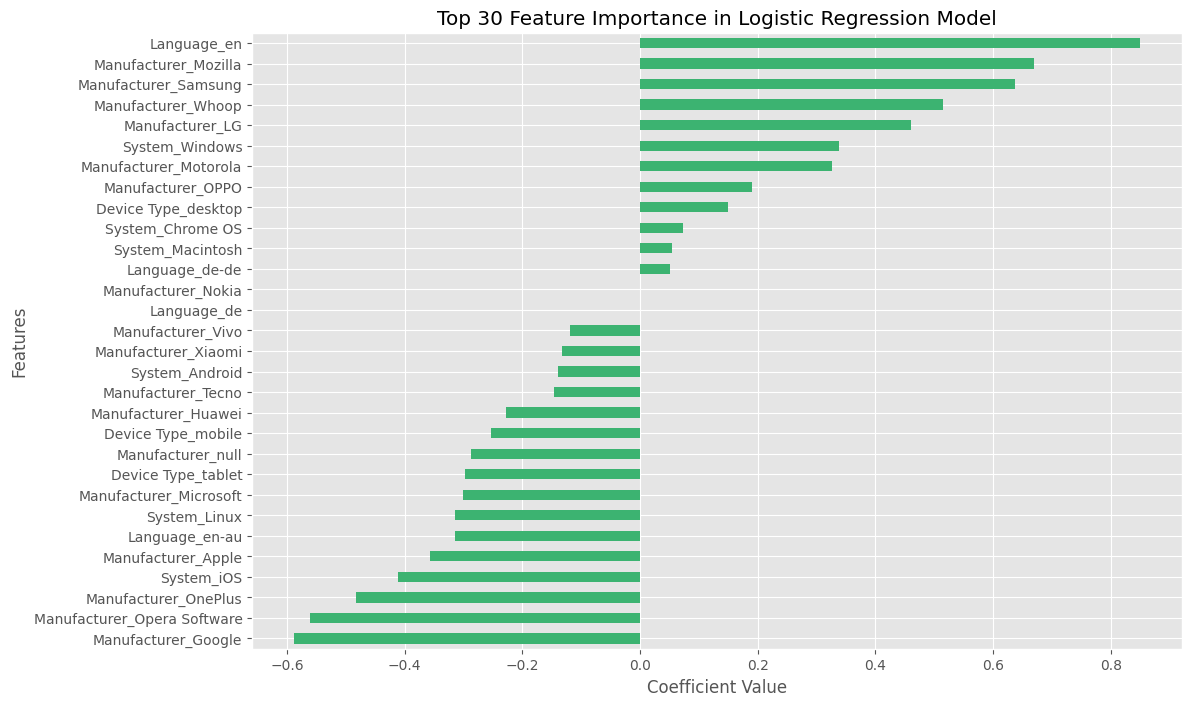

In [63]:
plt.figure(figsize=(12, 8))
feature_importance.head(30).sort_values().plot(kind='barh',color='mediumseagreen')
plt.title('Top 30 Feature Importance in Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

## 6. Final Thoughts
This is a one-day dataset, meaning many of the observation might be biased just on this one day performance. However, some of the key takeaways are as follows:

1. Google is still the biggest traffic source for the platform, and its drop-off rate is relatively low compared to other channels, meaning Google ads algorithm is still doing its job well.
2. Further investigation is needed to see why direct source has a high drop-off rate. If it's related to direct ads, cut the budget.
3. Safari (in-app) users are high in both drop-off rate and count. First thing that came to my mind is that there might be issues in mobile page support. Check the platform internally to see if there's anything we can do to improve user experience on mobile page, such as page resizing, feature loading time, coupon support when shopping on retailers' sites, etc. User experience might not be as good.

4. Non-US drop-off rates are high. Take Asia as an example. Asia is a top-5 region in user activity counts, but #1 in drop-off count with over 90% drop-off rate. Given Chinese (zh-cn and zh-tw) is a top 10 language in user activity, localization is required to help these users better understand what we offer.
5. Other non-US English speaking regions are high in drop-off rate as well, including Australia, UK, Canada, New Zealand, meaning there might be local online retailers that we have not covered yet. Identify their local online retailers and offer coupon to these users accordingly.
6. United States is still the major market. Promotion is neccesary for regions outside of LA. We've seen good amount of user activities in major cities such as Phoenix, Seattle, New York and New York. Add budget on Google Ads for users in these areas.

# Thank you for your time!